In [1]:
import torch
import numpy as np

In [2]:
import torch.nn as nn

In [3]:
torch.cuda.is_available()

True

In [4]:
from collections import deque

In [5]:
from tqdm import tqdm

In [24]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

In [25]:
import seaborn

In [7]:
num_agents = 4
state_size = 10

In [8]:
agent_qs = {}
for s in range(state_size):
    agent_qs[s] = np.random.uniform(size=num_agents)*2-1

In [9]:
rnd_states = {}
for s in range(state_size):
    rnd_states[s] = np.random.uniform(size=state_size)*2-1

In [10]:
def states(t):
    r = np.random.randint(state_size)
#     r = np.random.choice(range(state_size), p=[1/state_size + min(0, a + t*state_size) for a in range(state_size)])
    state = rnd_states[r]
    return state, r

In [11]:
reg_targets = {}
for s in range(state_size):
    reg_targets[s] = np.random.uniform()*10

In [12]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
        self.hyper_w = nn.Sequential(nn.Linear(state_size, 32), nn.ReLU(), nn.Linear(32, num_agents))
        self.v = nn.Sequential(nn.Linear(state_size,1))
    
    def forward(self, x, s):
        w_abs = torch.abs(self.hyper_w(s)).view(-1, num_agents, 1)
        y = torch.bmm(x.unsqueeze(1), w_abs)
        q = y + self.v(s)
        return q

In [13]:
class DoubleLinearNet(nn.Module):
    def __init__(self):
        super(DoubleLinearNet, self).__init__()

        self.hyper_w1 = nn.Sequential(nn.Linear(state_size, 32), nn.ReLU(), nn.Linear(32, 32 * num_agents))
        self.hyper_w2 = nn.Sequential(nn.Linear(state_size, 32), nn.ReLU(), nn.Linear(32, 32))
        self.v = nn.Sequential(nn.Linear(state_size,1))
    
    def forward(self, x, s):
        w1_abs = torch.abs(self.hyper_w1(s)).view(-1, num_agents, 32)
        w2_abs = torch.abs(self.hyper_w2(s)).view(-1, 32, 1)
        y = torch.bmm(x.unsqueeze(1), w1_abs)
        z = torch.bmm(y, w2_abs)
        q = z + self.v(s)
        return q

In [14]:
class NonLinearNet(nn.Module):
    def __init__(self):
        super(NonLinearNet, self).__init__()

        self.hyper_w1 = nn.Sequential(nn.Linear(state_size, 32), nn.ReLU(), nn.Linear(32, 32 * num_agents))
        self.hyper_w2 = nn.Sequential(nn.Linear(state_size, 32), nn.ReLU(), nn.Linear(32, 32))
        self.v = nn.Sequential(nn.Linear(state_size,1))
    
    def forward(self, x, s):
        w1_abs = torch.abs(self.hyper_w1(s)).view(-1, num_agents, 32)
        w2_abs = torch.abs(self.hyper_w2(s)).view(-1, 32, 1)
        y = torch.bmm(x.unsqueeze(1), w1_abs)
        y = torch.nn.functional.elu(y)
        z = torch.bmm(y, w2_abs)
        q = z + self.v(s)
        return q

In [15]:
bs = 32
max_t = 2000

In [16]:
def train(net):
    net = net.cuda()
    optimiser = torch.optim.RMSprop(net.parameters(), lr=0.0005)
    data = []
    buffer = deque(maxlen=int(max_t/10))
    for t in tqdm(range(max_t)):
        s, sx = states(t/max_t)
        new_x = agent_qs[sx]
        new_y = reg_targets[sx]
        buffer.append((new_x, new_y, s))

        if len(buffer) > bs:
            samples_idxs = np.random.choice(len(buffer)-1, bs)
            samples_x = np.zeros(shape=(bs,num_agents))
            samples_y = np.zeros(shape=(bs,1))
            samples_states = np.zeros(shape=(bs, state_size))
            for ex, ix in enumerate(samples_idxs):
                samples_x[ex] = buffer[ix][0]
                samples_y[ex] = buffer[ix][1]
                samples_states[ex] = buffer[ix][2]

            predicted = net(torch.tensor(samples_x, device="cuda", dtype=torch.float), torch.tensor(samples_states, device="cuda", dtype=torch.float))
            targets = torch.tensor(samples_y, device="cuda", dtype=torch.float)

            loss = ((predicted - targets)**2).mean()
            data.append(loss.item())

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
    return data

In [17]:
linear_net = LinearNet()
l_n_loss = train(linear_net)

linear_double = DoubleLinearNet()
l2_n_loss = train(linear_double)

non_linear = NonLinearNet()
nl_n_loss = train(non_linear)

100%|██████████| 2000/2000 [00:03<00:00, 533.30it/s]


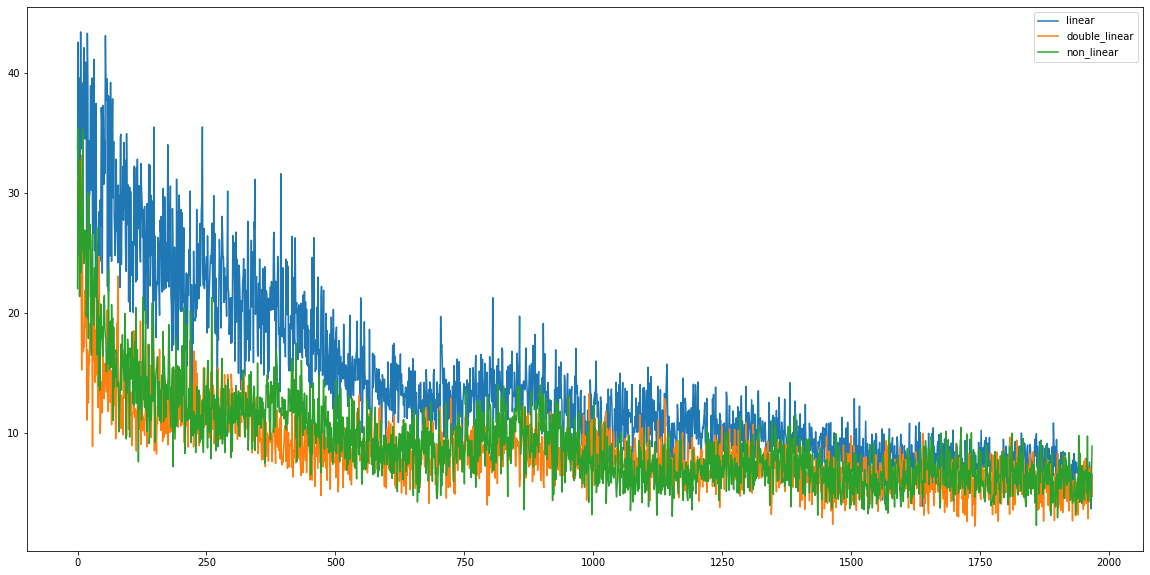

In [18]:
plt.figure(figsize=(20,10))
plt.plot(l_n_loss, label="linear")
plt.plot(l2_n_loss, label="double_linear")
plt.plot(nl_n_loss, label="non_linear")
# plt.xlim(0,1000)
plt.legend()

In [19]:
lin_loss = []
double_lin_loss = []
non_lin_loss = []
for _ in range(10):
    linear_net = LinearNet()
    l_n_loss = train(linear_net)
    lin_loss.append(l_n_loss)

    linear_double = DoubleLinearNet()
    l2_n_loss = train(linear_double)
    double_lin_loss.append(l2_n_loss)

    non_linear = NonLinearNet()
    nl_n_loss = train(non_linear)
    non_lin_loss.append(nl_n_loss)

100%|██████████| 2000/2000 [00:03<00:00, 530.50it/s]


<IPython.core.display.Javascript object>


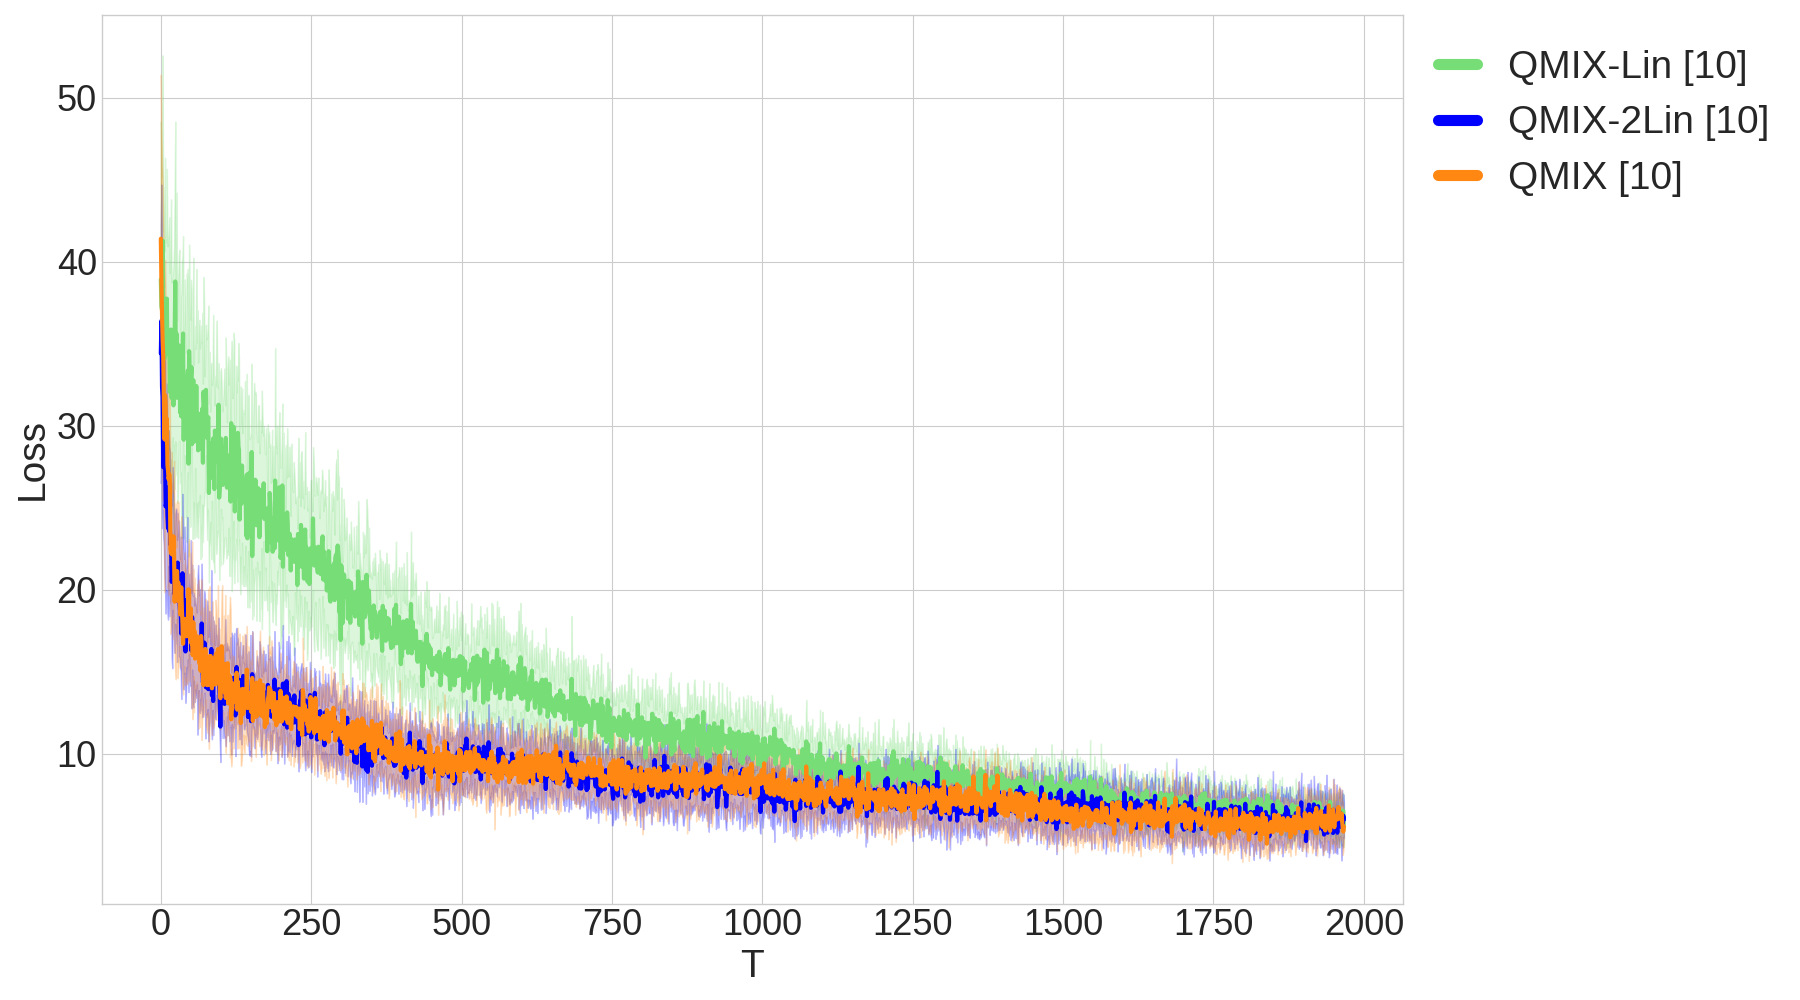

In [29]:
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots()
fig.set_size_inches(18,10)
# plt.figure(figsize=(20,10))

for xs, name, color in [(lin_loss, "QMIX-Lin", "#77dd77"), (double_lin_loss, "QMIX-2Lin", "blue"), (non_lin_loss, "QMIX", "#ff8712")]:
    np_data = np.array(xs)
    mean = np.mean(np_data, axis=0)
    std = np.std(np_data, axis=0)
    
    plt.plot(mean, label="{} [{}]".format(name, len(xs)), color=color, linewidth=3)
    plt.fill_between(range(len(mean)), mean+std, mean-std, alpha=0.25, color=color)
# plt.plot(l_n_loss, label="linear")
# plt.plot(l2_n_loss, label="double_linear")
# plt.plot(nl_n_loss, label="non_linear")
# plt.xlim(0,1000)
plt.legend()
plt.xlabel("T")
plt.ylabel("Loss")

axes.tick_params(labelsize=26)
axes.title.set_fontsize(30)
axes.xaxis.label.set_fontsize(28)
axes.yaxis.label.set_fontsize(28)
axes.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=28, handlelength=1, frameon=False)
for line in axes.legend_.get_lines():
    line.set_linewidth(8)
fig.tight_layout()